# Overview

All scenario's notebooks have the same structure:

- [Description of the scenario](#description)
- [Analysis of the calibration step in the real world and obtain calibration values for SimGrid's execution](#calibration)
- [Analysis of the execution of the scenario and comparison with the predicted results obtained in SimGrid](#comparison)

# Initialization code

In [3]:
library(viridis)
library(ggplot2)
library(plotly)
library(plyr)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/microservices_simgrid_reproductibility/comparison"

<a id='description'></a>
# 2nd scenario results

This file describes the steps used to perform the experiment, and provides visualizations of the results.

## Scenario

The scenario consists in 2 computing node. The datasource will send requests to the first computing node.
Work amounts (loop iterations) are the same on both compute nodes and the experiment is launched several times with different amount of works. The first node once done processing the request sends it to the second node through rabbitmq, which will in turn send the result to the sink once finished as in scenario 1.

The experiment lasts for 5 minutes and is repeated 4 times for each work amount (40*4=160 launches) to limit random effects.

Here are the parameters used:

```
----------------------------------------------------
PARAMETERS:
suffix: reprodscen2
Parallelization degree: 8
HostLogPath: /home/ccourageuxsudan/logs_expe/goLogs/reprod_scenario2_2021-04-09_09-11-28/
nbIters: start=1, end=80000001, iter=2000000
Samples: 4
Timestamp file: /go/src/app/timestamps/default5TimeStamps.csv
First core used: 0
----------------------------------------------------

```

## Reproduce

This scenario was launched on Grid'5000's parasilo cluster.

Example of node reservation: `oarsub -p "cluster='paravance'" -l host=4,walltime=6 -I`

The experiment was launched using: `repoPath="/home/ccourageuxsudan/SGMicroservices/calvin-microbenchmarks/rabbitmqGo/" onG5K=1 run=1 scenario=1 bash launcherReproduce.s`

## Output

Output logs for this scenario can be found under:

- For the calibration step: `results_reprod/microbenchmarks/reprod_calib_2021-04-09_09-11-28/`
- For the execution: `results_reprod/microbenchmarks/reprod_scenario2_2021-04-09_09-11-28/`

## Synthetic Loads


We use 2 synthetic workloads to perform our experiments:

- Calibration workload: one request triggered every 3 seconds for 5 minutes (300 seconds)
- Execution workload: varying workload generated using LIMBO, with 3 spikes


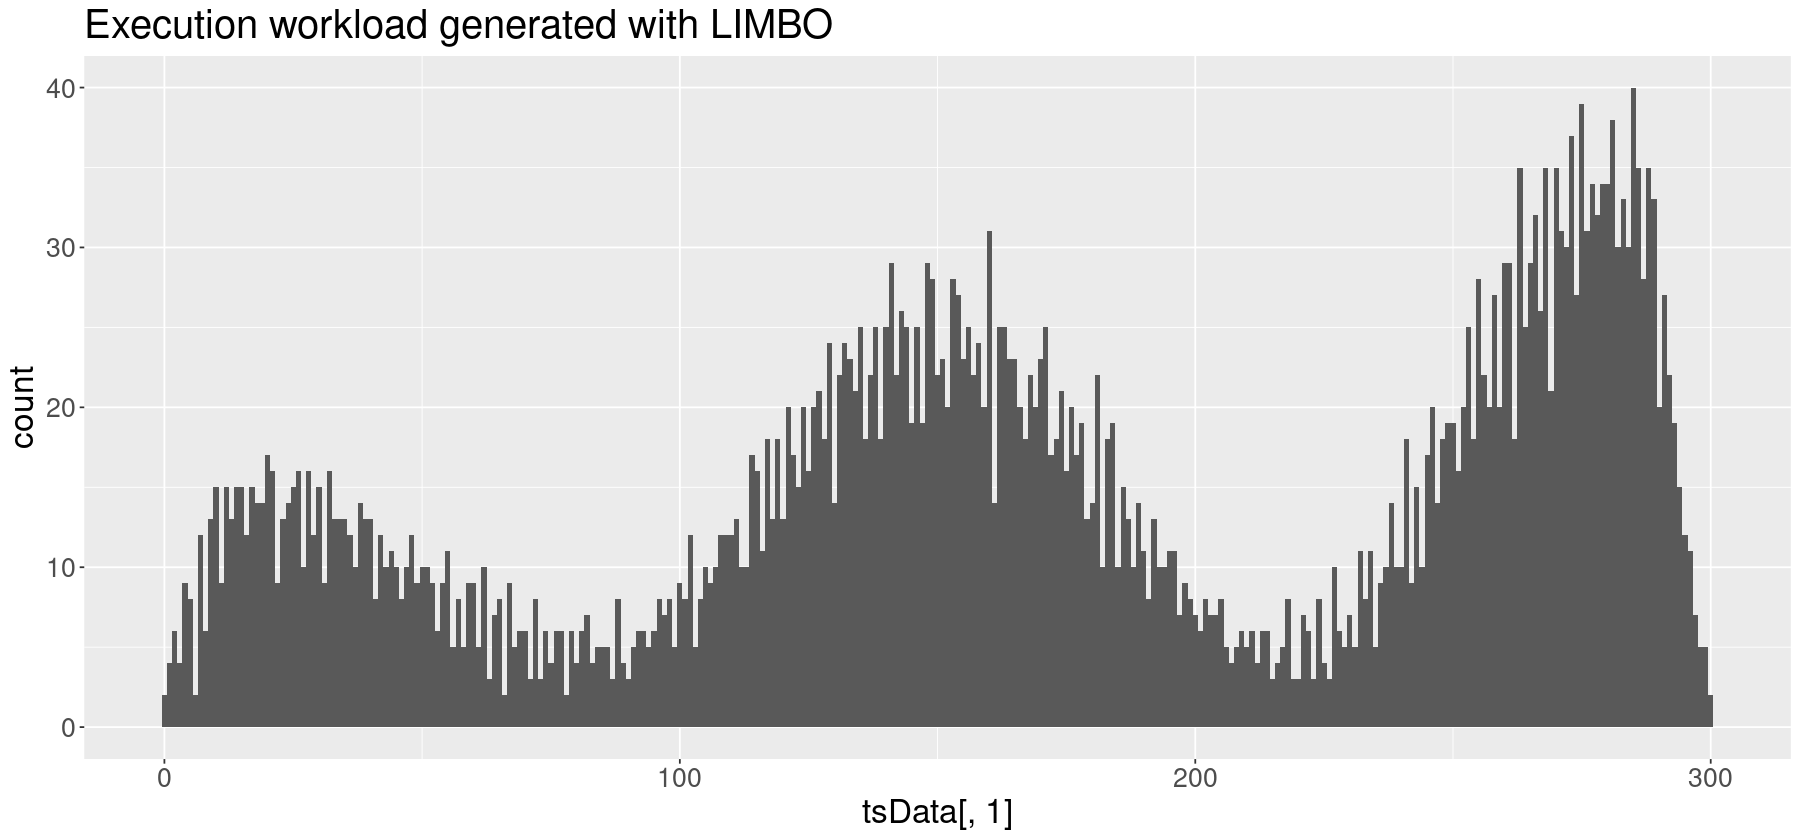

In [4]:
options(repr.plot.width=15, repr.plot.height=7)

tsData <- read.csv("./results_reprod/microbenchmarks/tsload.csv")

colnames(tsData) <- c("timestamp")

ggplot(tsData, aes(x=tsData[,1])) +
    geom_histogram(binwidth=1) +
    theme(text = element_text(size = 20)) + 
    ggtitle("Execution workload generated with LIMBO")

# Load Datasets

In [5]:
##### CALIBRATION
data_calibration <- as_tibble(read.csv("./results_reprod/microbenchmarks/reprod_calib_2021-04-09_09-11-28/2_aggrResults_1-10000000-100000002_4.csv"))

# preprocess to obtain timestamps as seconds instead of microseconds
data_calibration$timestampSec <- as.numeric(as.character(data_calibration$timestamp)) / 1e9
data_calibration$computeDurSec <- as.numeric(as.character(data_calibration$computeDur)) / 1e9
data_calibration$computeNode <- sub("\\_.*", "", data_calibration$serviceName)
summary(data_calibration)


data_calibration_sg <- as_tibble(read.csv("./results_reprod/microbenchmarks/sg_cal_scenario2.csv"))
summary(data_calibration_sg)

###### LOAD EXECUTION
data_SG_load <- as_tibble(read.csv("./results_reprod/microbenchmarks/sg_load_scenario2.csv"))
data_load_RW <- as_tibble(read.csv("./results_reprod/microbenchmarks/reprod_scenario2_2021-04-09_09-11-28/2_aggrResults_1-2000000-80000001_4.csv"))
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9
data_load_RW$computeNode <- sub("\\_.*", "", data_load_RW$serviceName)
summary(data_load_RW)


 serviceName            nbIter        timestamp          totDurInServ     
 Length:8800        Min.   :1e+00   Min.   :0.000e+00   Min.   :    1534  
 Class :character   1st Qu.:2e+07   1st Qu.:7.425e+10   1st Qu.: 7314845  
 Mode  :character   Median :5e+07   Median :1.485e+11   Median :17140982  
                    Mean   :5e+07   Mean   :1.485e+11   Mean   :17284928  
                    3rd Qu.:8e+07   3rd Qu.:2.228e+11   3rd Qu.:26610439  
                    Max.   :1e+08   Max.   :2.970e+11   Max.   :42417318  
   computeDur          parExec       totReqProcessed   scenario        
 Min.   :     238   Min.   :0.0000   Min.   : 0.00   Length:8800       
 1st Qu.: 7312998   1st Qu.:0.0000   1st Qu.:24.75   Class :character  
 Median :17138331   Median :1.0000   Median :49.50   Mode  :character  
 Mean   :17282623   Mean   :0.5389   Mean   :49.50                     
 3rd Qu.:26607882   3rd Qu.:1.0000   3rd Qu.:74.25                     
 Max.   :42412331   Max.   :1.0000   Max.  

       ts              qArr           instArr          startEx      
 Min.   :  4.00   Min.   :  4.00   Min.   :  4.00   Min.   :  4.00  
 1st Qu.: 76.04   1st Qu.: 76.02   1st Qu.: 76.02   1st Qu.: 76.02  
 Median :151.02   Median :151.00   Median :151.00   Median :151.00  
 Mean   :151.03   Mean   :151.01   Mean   :151.01   Mean   :151.01  
 3rd Qu.:226.01   3rd Qu.:226.00   3rd Qu.:226.00   3rd Qu.:226.00  
 Max.   :298.07   Max.   :298.03   Max.   :298.03   Max.   :298.03  
     endEx            flops              serv          
 Min.   :  4.00   Min.   :  261400   Length:2178       
 1st Qu.: 76.04   1st Qu.: 7069400   Class :character  
 Median :151.02   Median :17281400   Mode  :character  
 Mean   :151.03   Mean   :17281400                     
 3rd Qu.:226.01   3rd Qu.:27493400                     
 Max.   :298.07   Max.   :34301400                     

 serviceName            nbIter        timestamp          totDurInServ      
 Length:1428440     Min.   :1e+00   Min.   :0.000e+00   Min.   :     1201  
 Class :character   1st Qu.:2e+07   1st Qu.:1.180e+11   1st Qu.:  7072076  
 Mode  :character   Median :4e+07   Median :1.680e+11   Median : 14483456  
                    Mean   :4e+07   Mean   :1.728e+11   Mean   : 27905820  
                    3rd Qu.:6e+07   3rd Qu.:2.600e+11   3rd Qu.: 26983494  
                    Max.   :8e+07   Max.   :3.008e+11   Max.   :280959567  
   computeDur           parExec       totReqProcessed   scenario        
 Min.   :      236   Min.   :-1.000   Min.   :   0    Length:1428440    
 1st Qu.:  7070005   1st Qu.: 0.000   1st Qu.:1088    Class :character  
 Median : 14481528   Median : 1.000   Median :2177    Mode  :character  
 Mean   : 27659129   Mean   : 1.539   Mean   :2176                      
 3rd Qu.: 26918540   3rd Qu.: 2.000   3rd Qu.:3265                      
 Max.   :269495304   Max.   : 

<a id='calibration'></a>
# Calibration Step

We perform it with one compute node only since they would execute on different cores and would both give very similar output.

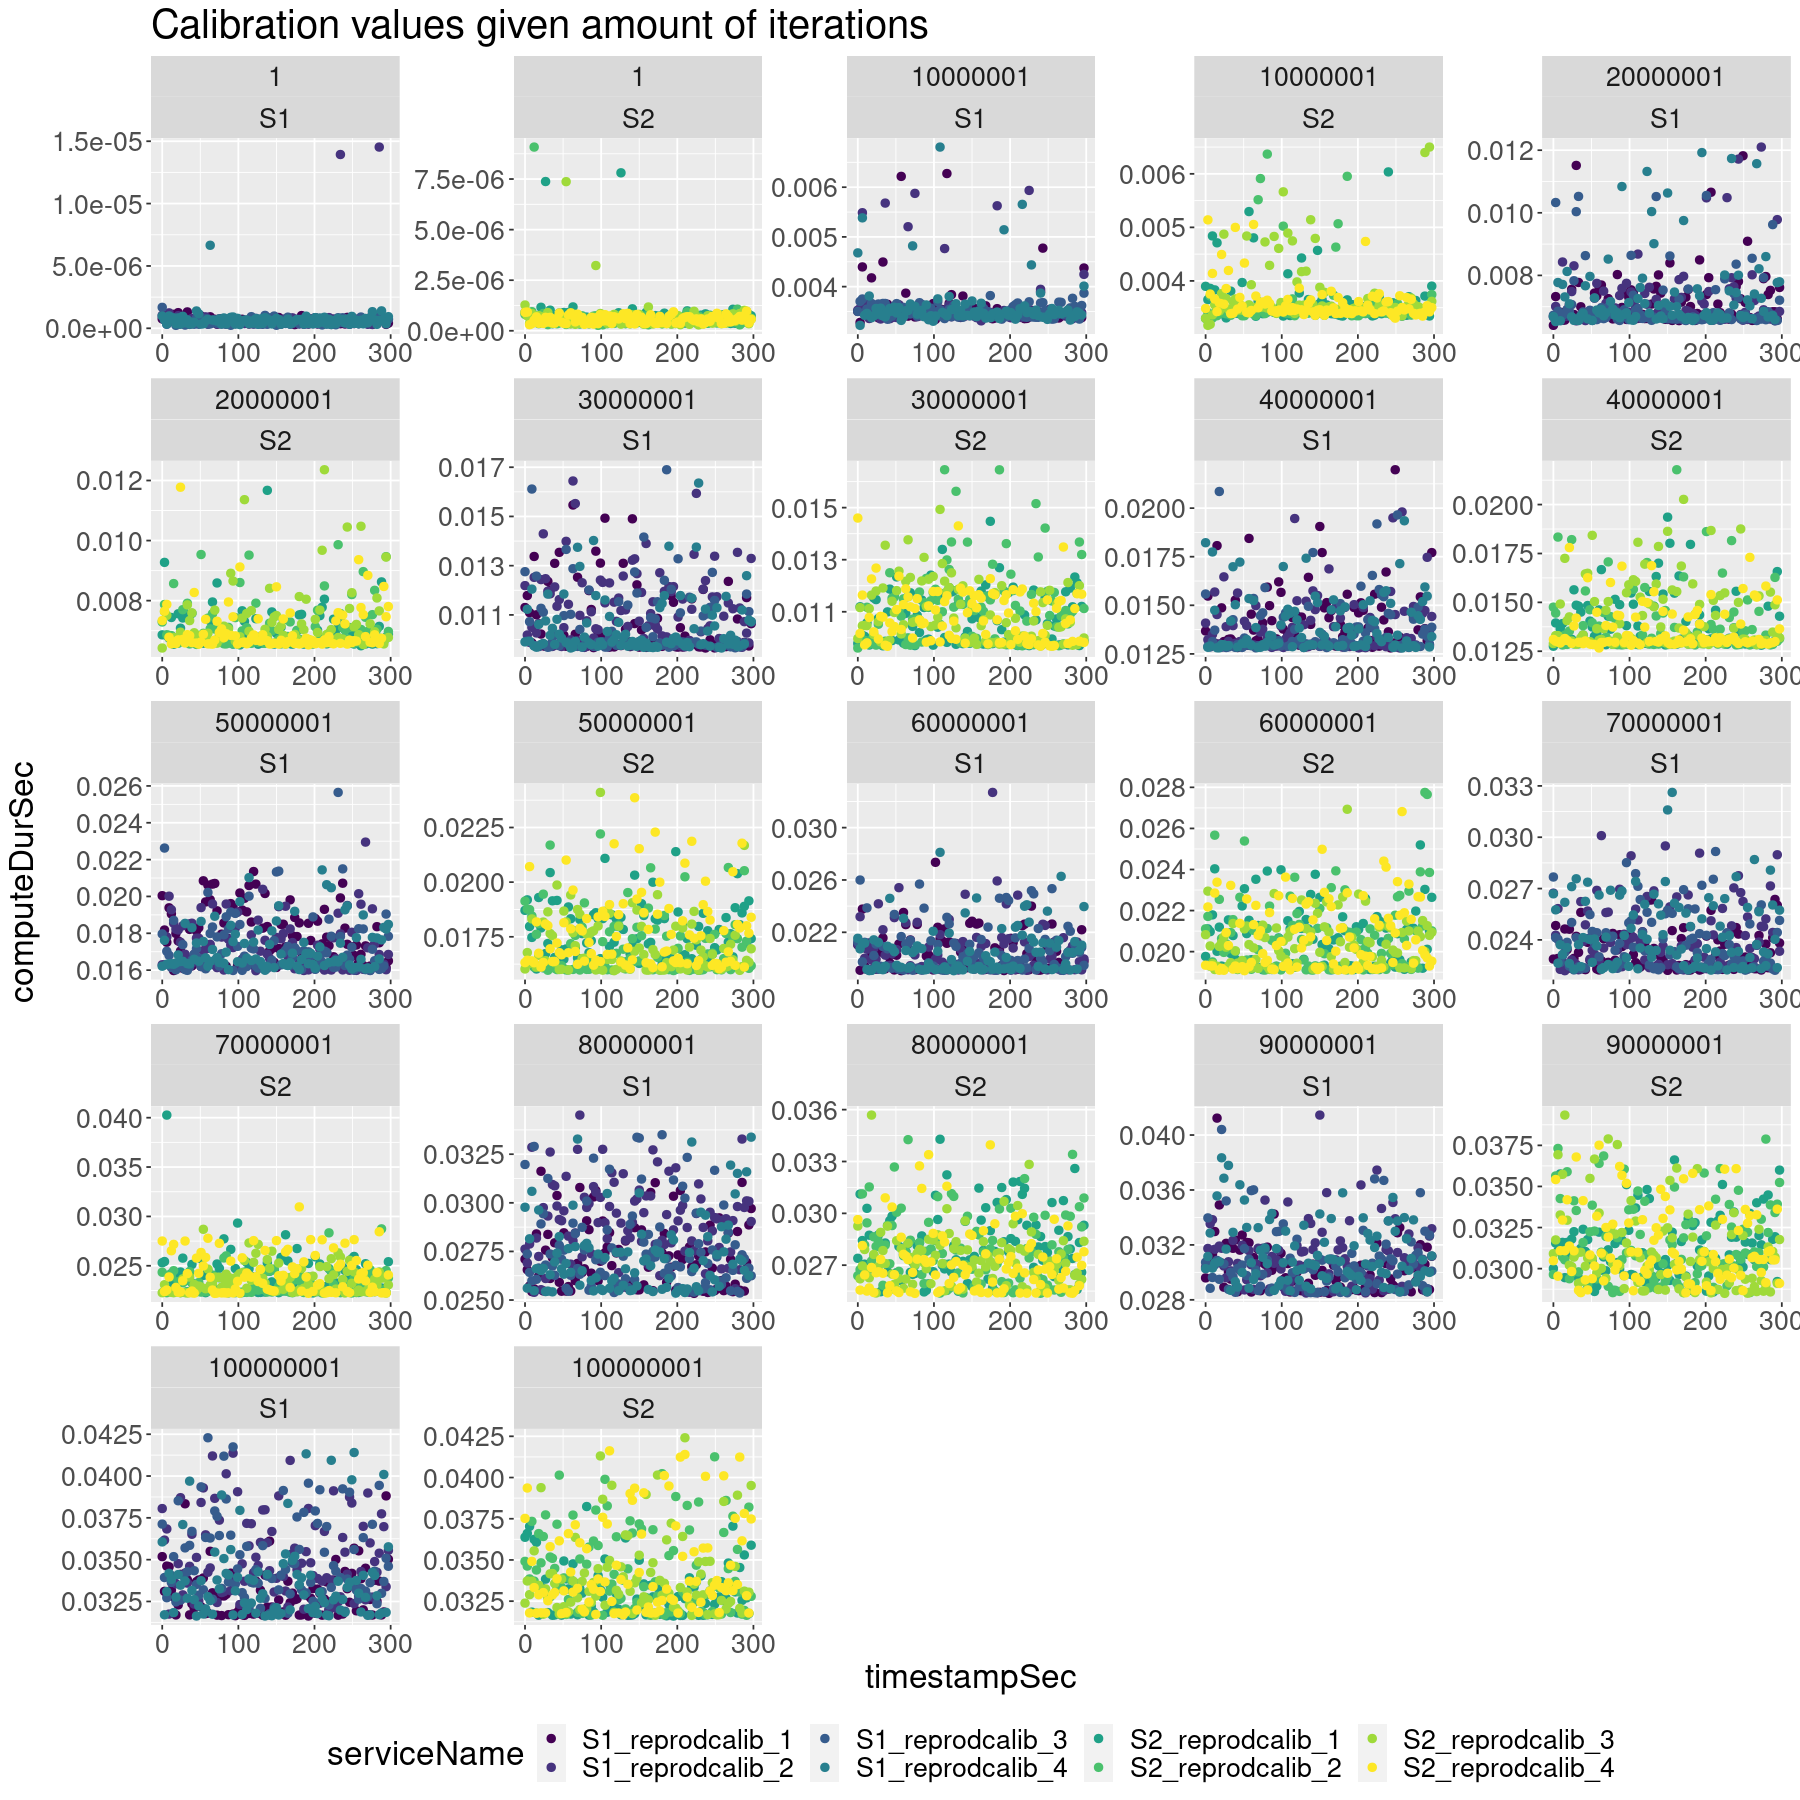

In [6]:
options(repr.plot.width=15, repr.plot.height=15)
ggplot(data_calibration, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=2)+
    ggtitle("Calibration values given amount of iterations")+
    facet_wrap(nbIter ~ computeNode, scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) 

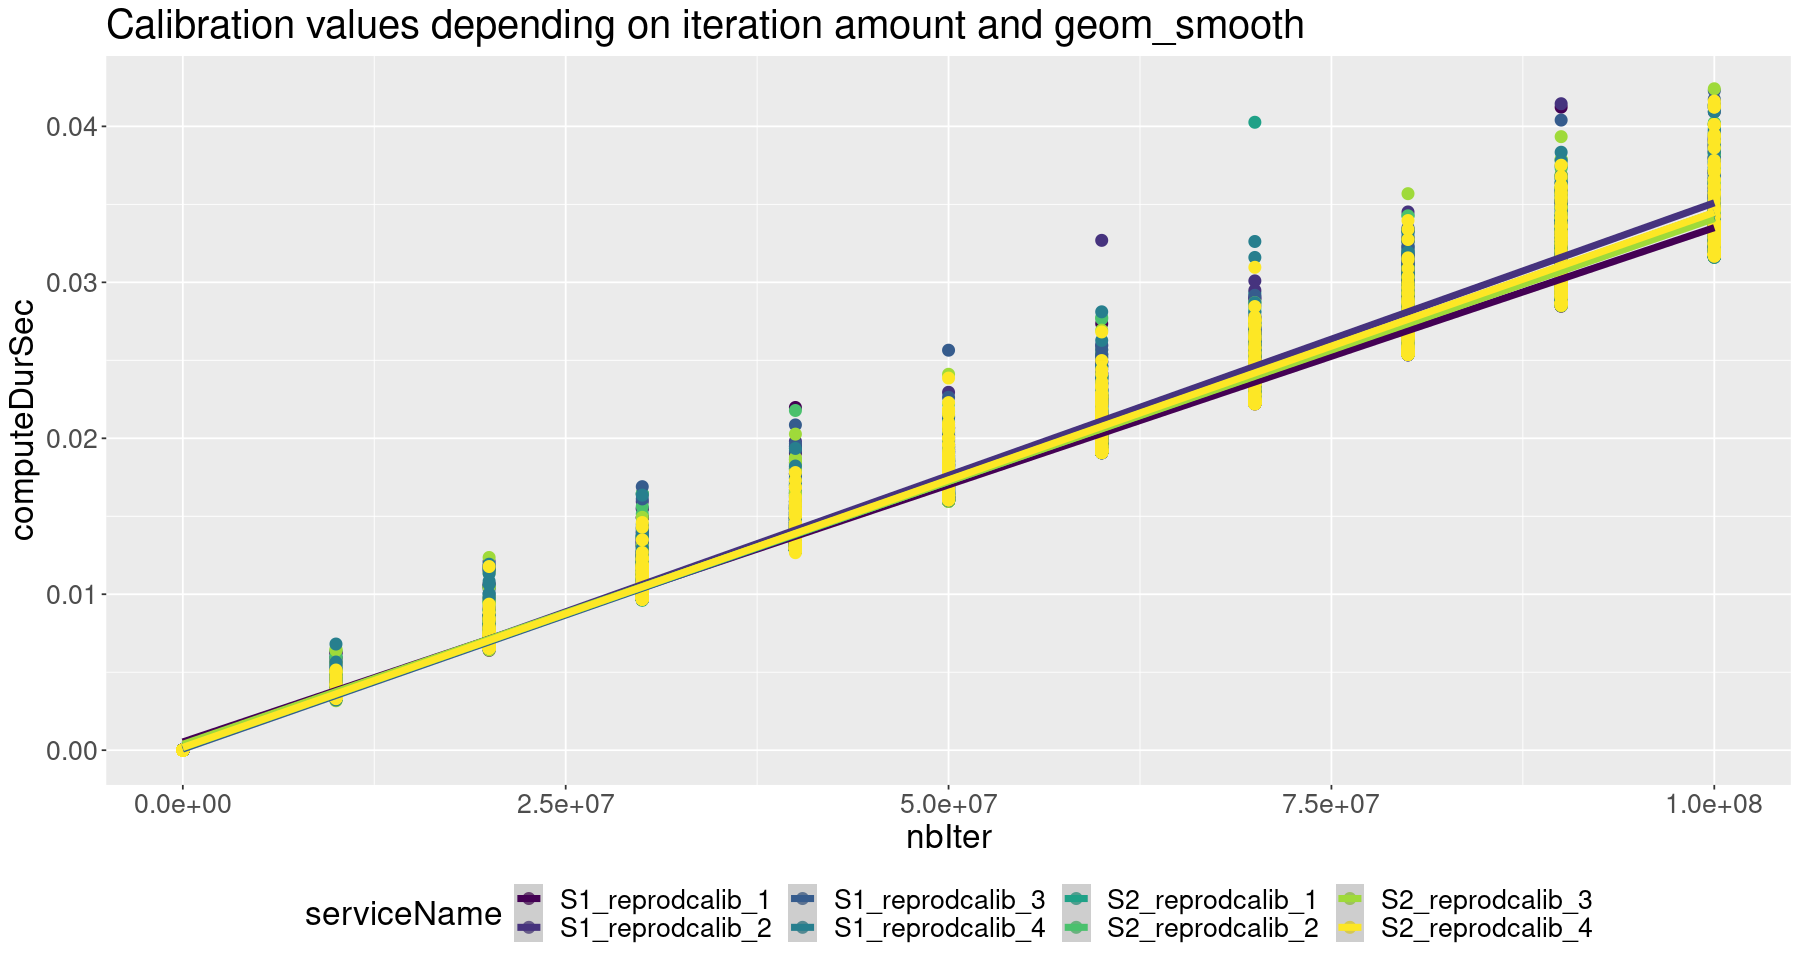

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data_calibration, aes(x=nbIter, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) + 
    ggtitle("Calibration values depending on iteration amount and geom_smooth")+
    geom_smooth(formula = y ~ x, method='lm', size=2)

## Linear regression to obtain calibration values

Given the previous graph, we can clearly observe (as expected) a linear relationship between the amount of work of the compute node, and the duration to execute a request. Thus we can use a linear regression to estimate the duration of a request given an amount of work (as a number of iterations). This value will then be used to calibrate our SimGrid code.

In [8]:
calibrationRegression = lm(computeDurSec ~ nbIter, data=data_calibration)
summary(calibrationRegression)


Call:
lm(formula = computeDurSec ~ nbIter, data = data_calibration)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0027073 -0.0008963 -0.0002609  0.0004578  0.0161718 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.614e-04  3.136e-05   8.335   <2e-16 ***
nbIter      3.404e-10  5.301e-13 642.172   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001573 on 8798 degrees of freedom
Multiple R-squared:  0.9791,	Adjusted R-squared:  0.9791 
F-statistic: 4.124e+05 on 1 and 8798 DF,  p-value: < 2.2e-16


The obtained equation is:
### ```dur = nbIter*3.404*10**(-10)+2.614*10**(-4)``` 

## Utility function to obtain duration from nbIter

In [9]:
nbIter_to_duration <- function(nbIter) {
  return (nbIter*3.404*10**(-10)+2.614*10**(-4))
}

# utilitary function
nbIter_to_duration_to_SG <- function(start, end, iter, fact=1) {
    for(i in seq(from=start, to=end, by=iter)){
        cat(paste(trunc(fact*nbIter_to_duration(i)*10^9)," "))
    }
}

# example
print(nbIter_to_duration(2.5*10**8))
print(nbIter_to_duration(5*10**8))
print(nbIter_to_duration(7.5*10**8))

[1] 0.0853614
[1] 0.1704614
[1] 0.2555614


## Calibration comparison between real world data and SimGrid

In [10]:
start=1
end=100000002
iter=10000000

nbIter_to_duration_to_SG(start, end, iter)

261400  3665400  7069400  10473400  13877400  17281400  20685400  24089400  27493400  30897400  34301400  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_cal_scenario2.csv
for i in 261400  3665400  7069400  10473400  13877400  17281400  20685400  24089400  27493400  30897400  34301400 
do
    echo "Calibration for iterAmount=$i"
    scenario=2 parDeg=8 tsFile=../rabbitmqGo/timestamps/tsCal.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_cal_scenario2.csv
done
```

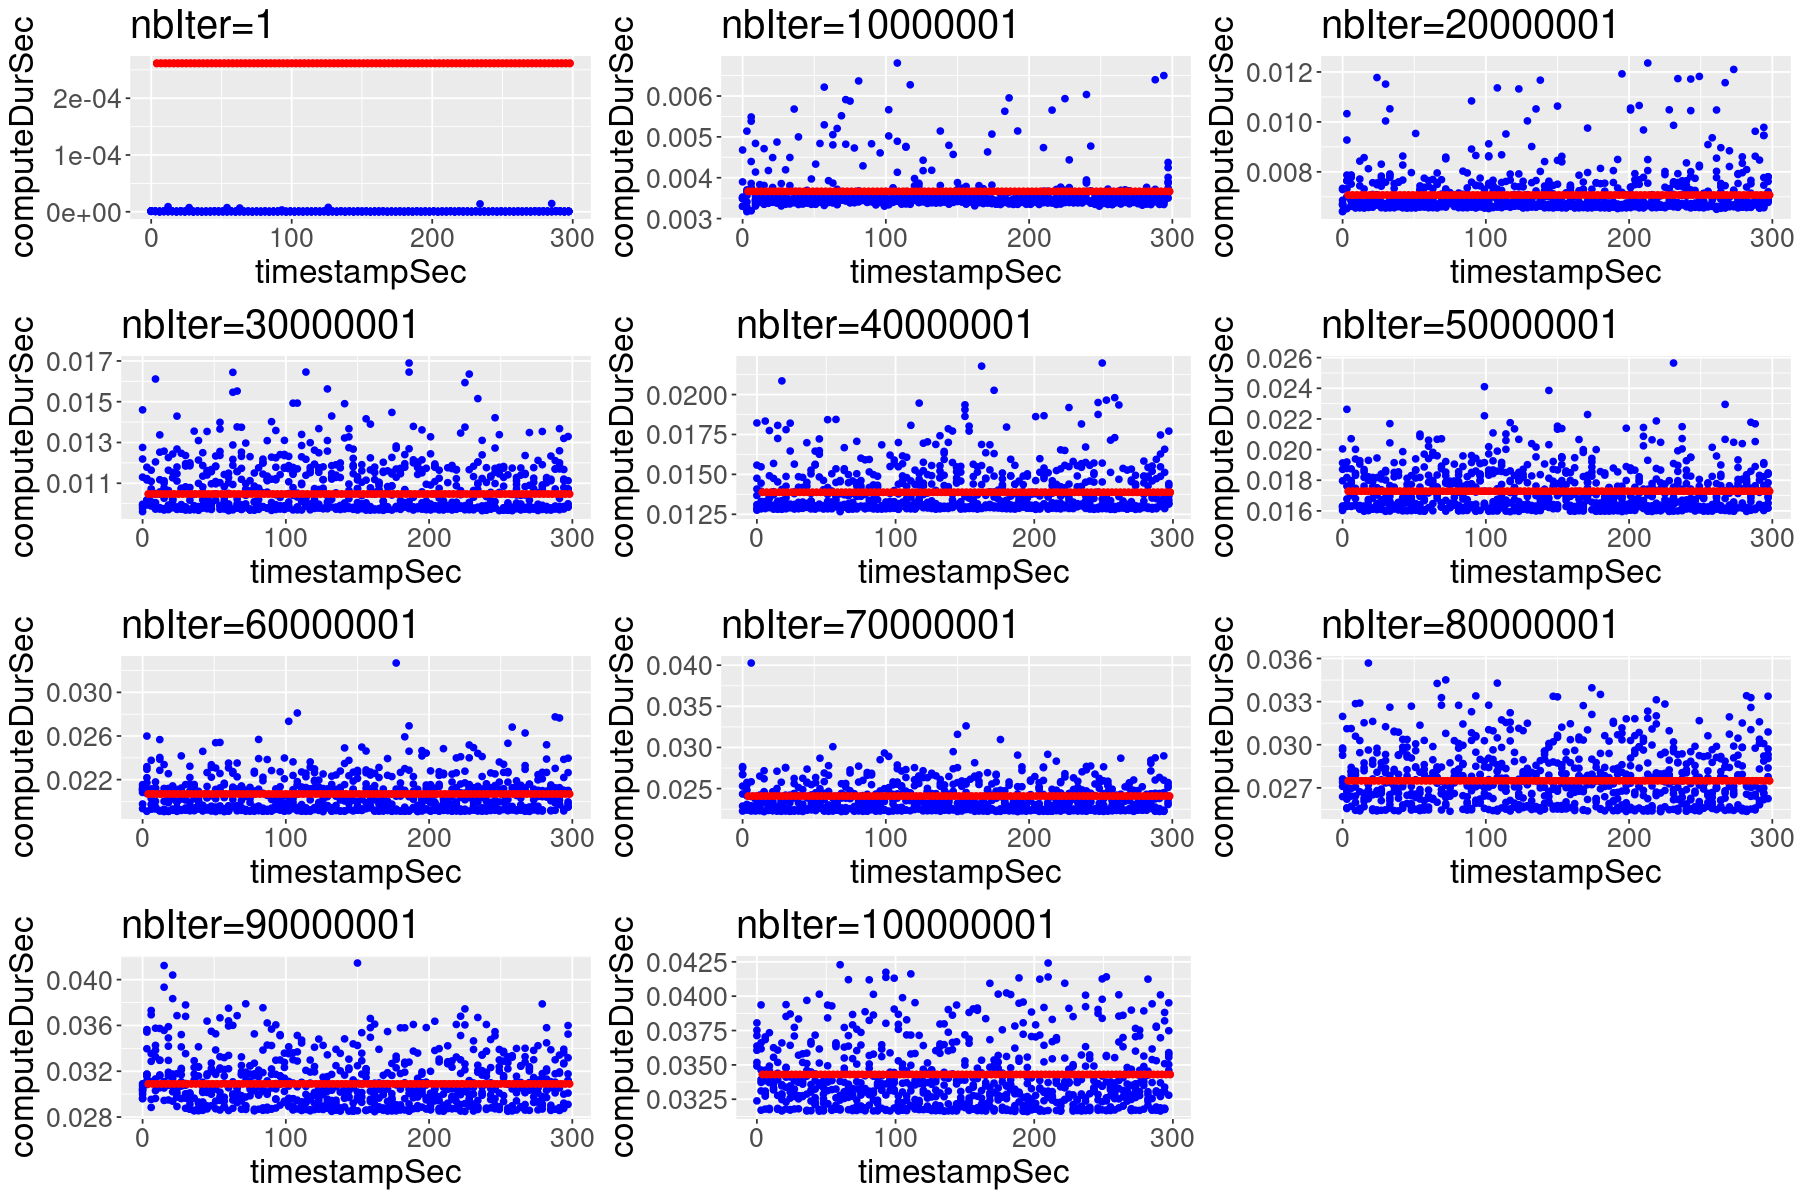

In [11]:
options(repr.plot.width=15, repr.plot.height=10)
P <- list()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red")+
        labs(title=sprintf("nbIter=%d",i))+
        theme(text = element_text(size = 20))+ 
        scale_color_viridis(discrete = TRUE, option = "D")+
        scale_fill_viridis(discrete = TRUE) 
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))

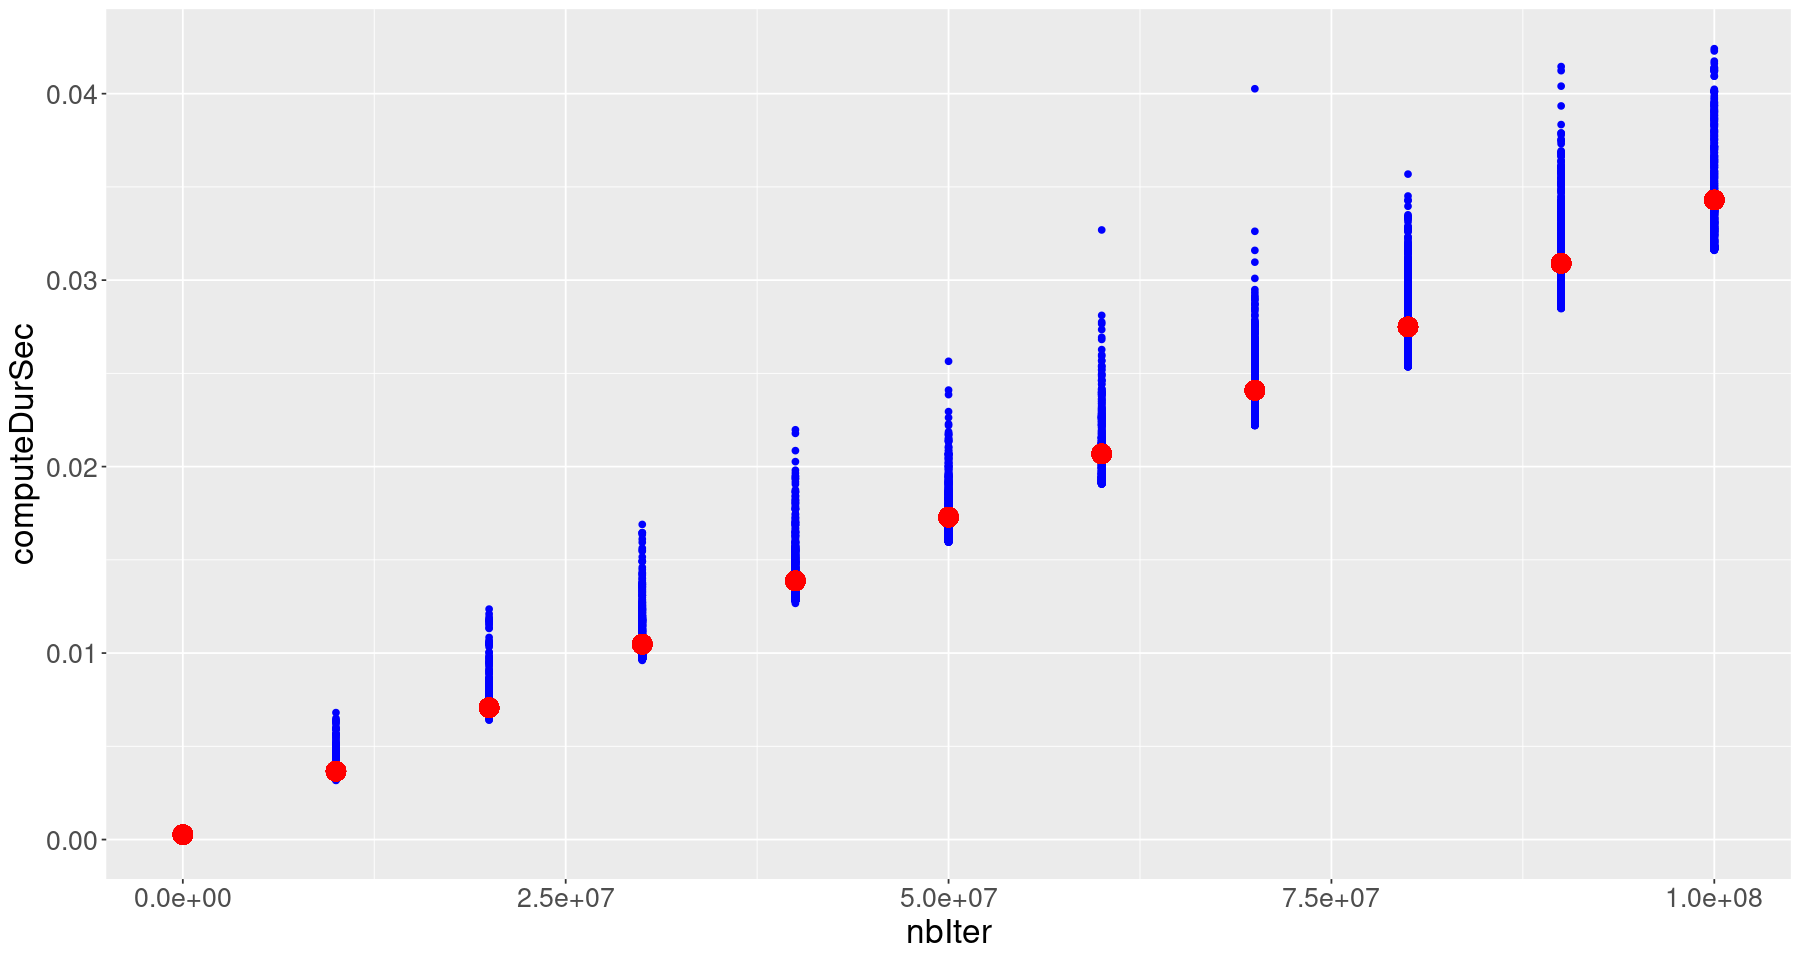

In [12]:

options(repr.plot.width=15, repr.plot.height=8)
P <- list()
g <- ggplot()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    tmpsg$nb <- i

    g <- g +
        geom_point(data = tmpG5K, aes(x=nbIter, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=nb, y=endEx-startEx), color = "red", size=5)+
        theme(text = element_text(size = 20))
    P <- c(P, list(g))
    
}
g

<a id='comparison'></a>
# Execution comparison


In [13]:
# obtain flop amount for 1GF nodes in SimGrid

start=1
end=80000001
iter=2000000

nbIter_to_duration_to_SG(start, end, iter)

261400  942200  1623000  2303800  2984600  3665400  4346200  5027000  5707800  6388600  7069400  7750200  8431000  9111800  9792600  10473400  11154200  11835000  12515800  13196600  13877400  14558200  15239000  15919800  16600600  17281400  17962200  18643000  19323800  20004600  20685400  21366200  22047000  22727800  23408600  24089400  24770200  25451000  26131800  26812600  27493400  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_load_scenario2.csv
for i in 261400  942200  1623000  2303800  2984600  3665400  4346200  5027000  5707800  6388600  7069400  7750200  8431000  9111800  9792600  10473400  11154200  11835000  12515800  13196600  13877400  14558200  15239000  15919800  16600600  17281400  17962200  18643000  19323800  20004600  20685400  21366200  22047000  22727800  23408600  24089400  24770200  25451000  26131800  26812600  27493400 
do
    echo "Calibration for iterAmount=$i"
    scenario=2 parDeg=8 tsFile=default5TimeStamps.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_load_scenario2.csv
done
```

# Time spent in first node

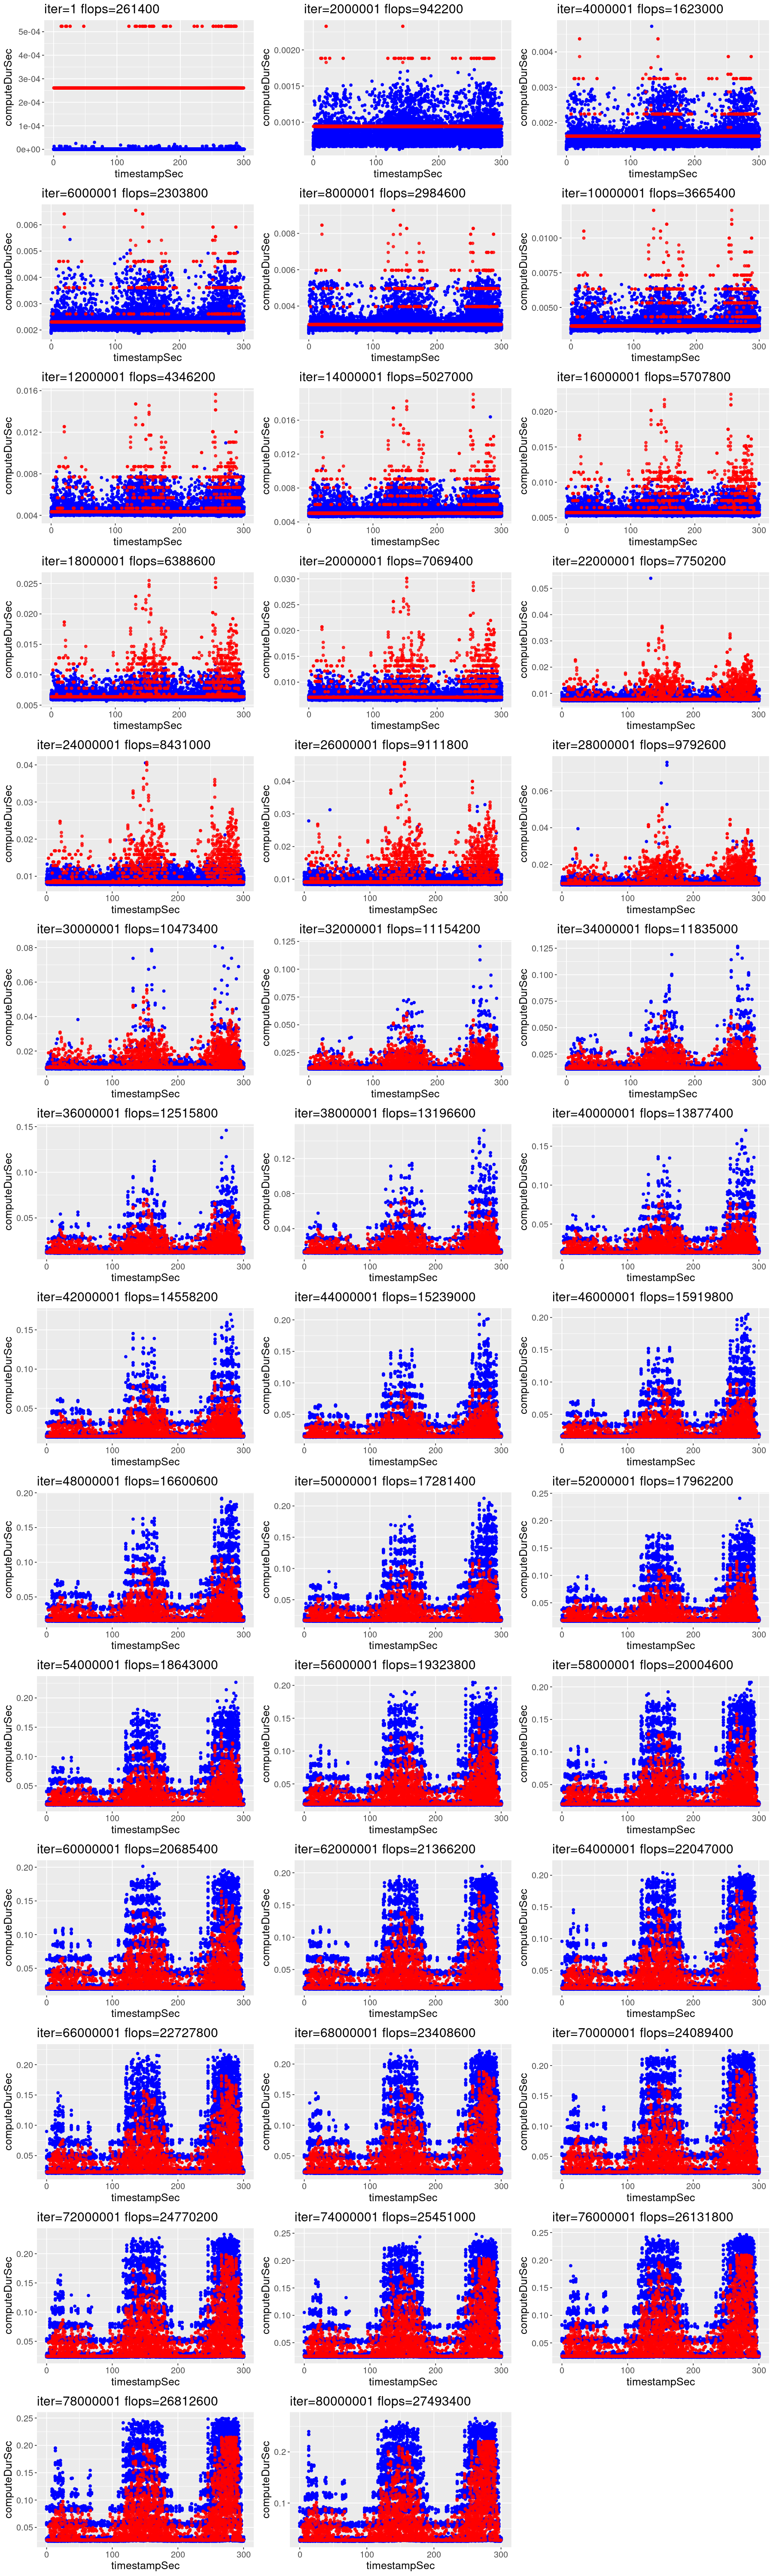

In [14]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, serv=="service1" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S1" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))


# Time spent in second node

In [ ]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, serv=="service2" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S2" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))
